## Importing neccessary liberaries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

import numpy as np

from sklearn.metrics import confusion_matrix

import cv2
from tensorflow.keras.utils import img_to_array
from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')


___________________________________________________________________________________________
## Seting image size, batch size and number of emotions (classes)

In [2]:
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 32
NUM_CLASSES = 7

___________________________________________________________________________________________
## Preparing ImageDataGenerator with the image augmentations needed:
rescaling,horizontal flip and rotation

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,
                                 rotation_range=15,
                                 fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255.)

_____________________________________________________________________________________________
## Importing the images from directories using the previously inisialized Image Data Generators

In [3]:

train_generator=train_datagen.flow_from_directory('Datasets/CK+48/train',
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  color_mode='grayscale')

valid_generator=test_datagen.flow_from_directory('Datasets/CK+48/test',
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  color_mode='grayscale')


Found 829 images belonging to 7 classes.
Found 152 images belonging to 7 classes.


__________________________________________________________________________
## Ploting images samples with their corrosponding classification

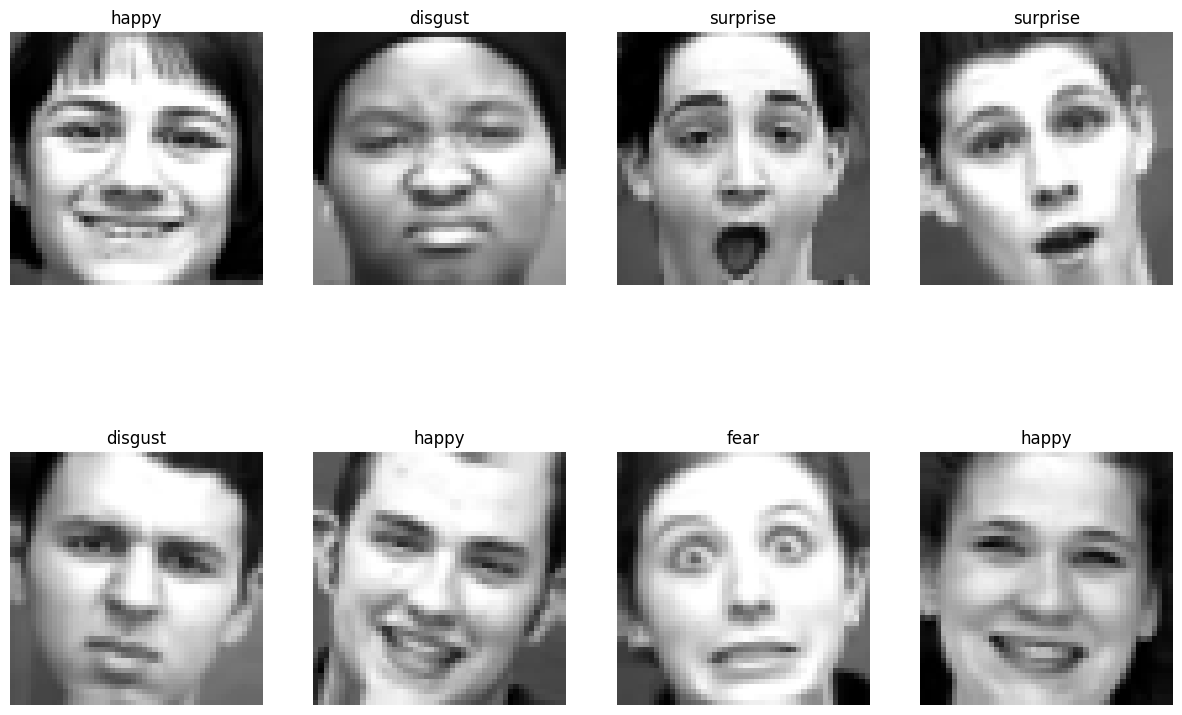

In [5]:
x,y=next(train_generator)

classes_names=list(train_generator.class_indices.keys())

def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(img[i], cmap='gray')
        plt.title(classes_names[np.argmax(labels[i])])
        plt.axis('off')
 
plot_images(x,y)

_______________________________________________________________________________________________
## Building the model 
<ol>
  <li>Inisialize the model with type Sequential</li>
  <li>add Conv2D layer with 32 filters(kernels) each kernel has a size of (3, 3)since the image size is fairly small </li>
  <li>add a max MaxPooling2D with pool size (2,2)</li>
  <li>add Conv2D layer again with 64 filters this time each filter has a size of (3, 3)</li>
  <li>add a max MaxPooling2D with pool size (2,2)</li>
  <li>add  a final Conv2D layer  with 64 filters again each filter has a size of (3, 3)</li>
  <li>flatten the output from the last Conv2D (turn it to 1D sequence) to prepare it to be fed into the next layer </li>
  <li> add a Dense layer (fully connected) with 64 neurons </li>
  <li>add a Dense layer with softmax activation function (since we are trying to do multiclass classification) with a neurone for each class (NUM_CLASSES) which is 7 in this case </li>
</ol>


In [10]:
model =Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))



## Compile the model with categorical_crossentropy as the loss function since it is a multiclass classification model

In [ ]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy', metrics = ['accuracy'])

_______________________________________________________________________________________________
## Add an early stopping to restore best weights and stop the training if the accuracy stopped improving after 10 epochs

In [11]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

__________________________________________________________________________________________
## Fiting (training) the model and saving the history for further analysis 

In [12]:
history = model.fit(train_generator,
					validation_data=valid_generator,
					epochs=40,
					callbacks=[early])

Epoch 1/40
26/26 [==============================] - 9s 256ms/step - loss: 1.8510 - accuracy: 0.2425 - val_loss: 1.7981 - val_accuracy: 0.2500
Epoch 2/40
26/26 [==============================] - 6s 222ms/step - loss: 1.7422 - accuracy: 0.3643 - val_loss: 1.5900 - val_accuracy: 0.5658
Epoch 3/40
26/26 [==============================] - 5s 179ms/step - loss: 1.3433 - accuracy: 0.5476 - val_loss: 1.0668 - val_accuracy: 0.5921
Epoch 4/40
26/26 [==============================] - 5s 181ms/step - loss: 0.9540 - accuracy: 0.6550 - val_loss: 0.6782 - val_accuracy: 0.7237
Epoch 5/40
26/26 [==============================] - 5s 205ms/step - loss: 0.6646 - accuracy: 0.7551 - val_loss: 0.5922 - val_accuracy: 0.7500
Epoch 6/40
26/26 [==============================] - 5s 203ms/step - loss: 0.5435 - accuracy: 0.7937 - val_loss: 0.4449 - val_accuracy: 0.8026
Epoch 7/40
26/26 [==============================] - 5s 187ms/step - loss: 0.5678 - accuracy: 0.7937 - val_loss: 0.3715 - val_accuracy: 0.8487
Epoch 

________________________________________________________________________________
## Plot Training and Validation accurarcy diagram

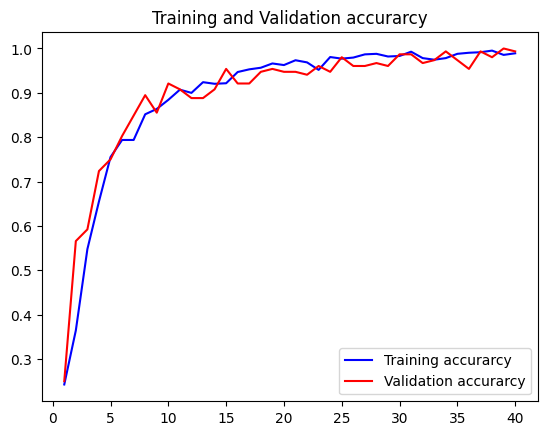

<Figure size 640x480 with 0 Axes>

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
plt.show()

___________________________________________________________________________________________
## Confusion matrix
producing the confusion matrix by predicting the validation set batch by batch and appending the results to an empty numpy array 


Accuracy over the test set: 
  99.34 %
1/1 [==============================] - 0s 103ms/step


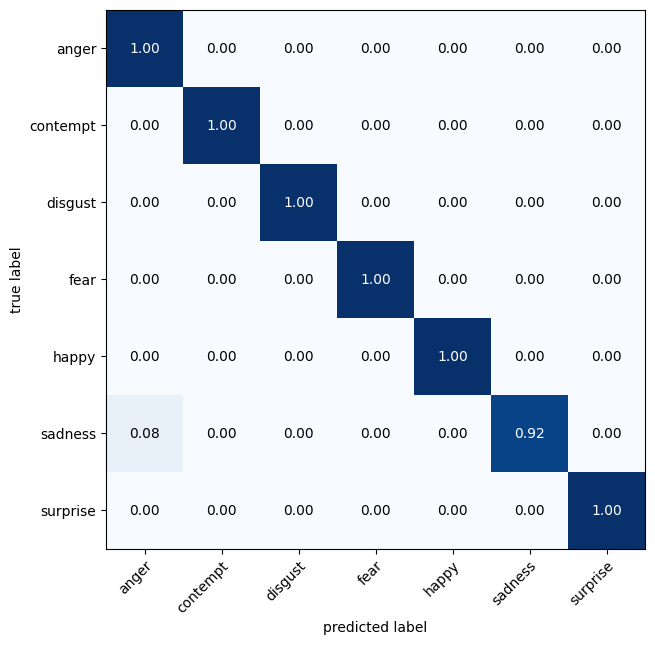

In [26]:
score = model.evaluate(valid_generator, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

y_pred=np.empty((BATCH_SIZE,))
y_true=np.empty((BATCH_SIZE,))
for i in range(len(valid_generator)):
    y_pred_temp = model.predict(valid_generator[i][0])
    y_pred_temp = np.array([np.argmax(x) for x in y_pred_temp])
    y_pred=np.append(y_pred,y_pred_temp)
    y_true_temp=np.array([np.argmax(x) for x in valid_generator[i][1]])
    y_true=np.append(y_true,y_true_temp) 
cm = confusion_matrix(y_true[BATCH_SIZE:], y_pred[BATCH_SIZE:])

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=classes_names,
                                figsize=(NUM_CLASSES, NUM_CLASSES))
fig.show()


___________________________________________________________________________________________
## Extract faces from an image and applying the model to predict the emotions 

Number of detected faces: 3
1/1 [==============================] - 0s 74ms/step


(-0.5, 310.5, 191.5, -0.5)

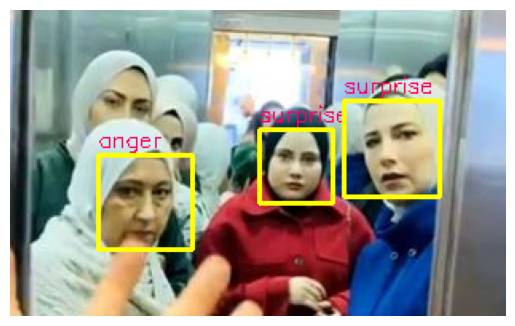

In [27]:
# read the input image
img = cv2.imread('aya.jpg')

# convert to grayscale of each frames
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# read haacascade to detect faces in input image
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# detects faces in the input image
faces = face_cascade.detectMultiScale(gray, 1.1, 2)
print('Number of detected faces:', len(faces))
# loop over all the detected faces
classes_name=list(train_generator.class_indices.keys())
for (x,y,w,h) in faces:
   fc = gray[y:y+h, x:x+w]
   roi = cv2.resize(fc, IMAGE_SIZE)
   roi = img_to_array(roi)  # Transforming image to array
   roi = roi / 255  # Normalizing Image
   roi = np.expand_dims(roi, axis=0)
   pred_im = model.predict(roi)
   text_idx=np.argmax(pred_im)
   text=classes_name[text_idx]
   cv2.putText(img, text, (x, y-5),
       cv2.FONT_HERSHEY_SIMPLEX, 0.45, (100, 0, 255), 1)
   # To draw a rectangle around the detected face  
   cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)

# Display an image 
plt.imshow(img[:,:,::-1])
plt.axis('off')
